## Общее описание:

Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

### План

1. **Сначала сделаем небольшой препроцессинг:**
   - Посмотрим на данные
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
   - Сформулируем предположения, которые будем тестировать
   - Создадим лейбл churn/not_churn
   - Построим графики
   - **Поинт:** только по графикам выводы делать – bad practice, хорошо подкреплять стат. тестами (и стат. тесты есть не только в A/B)
3. **Тестируем гипотезы:**
   - Выбираем гипотезу
   - Выбираем подходящий тест
   - Тестируем
4. **Подводим итоги:**
   - Сформулировать выводы и суммаризировать всё что было
   - Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше? Как можно будет позже провести A/B тестирование? (починить android приложение, возможно таргетить и мотивировать не очень активных водителей, улучшить программу лояльности и бонусов для водителей и тд и тп)


### Описание данных

- `city` – город
- `phone` – основное устройство, которое использует водитель
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal, norm, binom, expon, t, chi2, pareto, ttest_ind, sem, beta, laplace
import statsmodels.api as sa
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova
import pingouin as pg

from statsmodels.stats.proportion import proportion_confint
from seaborn import distplot
from matplotlib import pyplot


import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize': (12, 6)}, style="whitegrid")

## Подготовка

In [2]:
df = pd.read_csv(r'data\churn.csv')

In [3]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  
0                       4             True         46.2  
1                       0            False         50.0  
2                       3            False        100.0  
3                       9             True         80.0  
4                      14            False         82.4

In [4]:
df.shape

(50000, 12)

In [5]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [6]:
df.nunique()

avg_dist                  2908
avg_rating_by_driver        27
avg_rating_of_driver        37
avg_surge                  115
city                         3
last_trip_date             182
phone                        2
signup_date                 31
surge_pct                  367
trips_in_first_30_days      59
luxury_car_user              2
weekday_pct                666
dtype: int64

In [7]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

Изменяем тип для дат:


In [8]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [10]:
df.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   
std        5.707357              0.446652              0.617338      0.222336   

                      last_trip_date                 signup_date  \
count                          50000                       50000   
mean   2014-04-19 08:02:04.992000256  2014-01-16 13:04:20.352000   
min              2014-01-01 00:00:00         2014-01-01 00:00:00   
25%              2014-02-14 00:00:00         2014-01-09 00:00:00   
50%              2014-05-08 00:00:00         2014-01-17 00:00:00   
75%              2014-06-18 00:00:00         2014-01-24 00:00:00   
max              2014-07-01 00:00:00         2014-01-31 00:00:00   
std                              NaN                         NaN   

          surge_pct  trips_in_first_30_days   weekday_pct  
count  50000.000000            50000.000000  50000.000000  
mean       8.849536                2.278200     60.926084  
min        0.000000                0.000000      0.000000  
25%        0.000000                0.000000     33.300000  
50%        0.000000                1.000000     66.700000  
75%        8.600000                3.000000    100.000000  
max      100.000000              125.000000    100.000000  
std       19.958811                3.792684     37.081503

In [11]:
df.describe(include='object')

city   phone
count        50000   49604
unique           3       2
top     Winterfell  iPhone
freq         23336   34582

In [12]:
df.describe(include='datetime')

last_trip_date                 signup_date
count                          50000                       50000
mean   2014-04-19 08:02:04.992000256  2014-01-16 13:04:20.352000
min              2014-01-01 00:00:00         2014-01-01 00:00:00
25%              2014-02-14 00:00:00         2014-01-09 00:00:00
50%              2014-05-08 00:00:00         2014-01-17 00:00:00
75%              2014-06-18 00:00:00         2014-01-24 00:00:00
max              2014-07-01 00:00:00         2014-01-31 00:00:00

In [13]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  
0                       4             True         46.2  
1                       0            False         50.0  
2                       3            False        100.0  
3                       9             True         80.0  
4                      14            False         82.4

## 2: графики, гипотезы и тесты


Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней (но можно попробовать и другие значения в зависимости от вашей компании/данных)


In [14]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [15]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

In [16]:
df['days_since_last_trip']

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

Преобразуем в int:


In [17]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [18]:
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

In [19]:
df['churn'] = df.days_since_last_trip.apply(
    lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

days_since_last_trip      churn
0                        14  not_churn
1                        57      churn
2                       175      churn
3                         2  not_churn
4                       108      churn
...                     ...        ...
49995                    26  not_churn
49996                   157      churn
49997                    40      churn
49998                   167      churn
49999                    72      churn

[50000 rows x 2 columns]

### churn


In [20]:
df.churn.value_counts(normalize=True).mul(100)

churn
churn        62.392
not_churn    37.608
Name: proportion, dtype: float64

In [21]:
fig = px.histogram(df, x='churn')
fig.show()

Еще лучше – отразим на графике нормализованные значения (сравниваем не сырые числа):


In [22]:
fig = px.histogram(df, x='churn', histnorm='probability density')
fig.show()

### churn & phone

Предположим, что проблема может быть среди юзеров на конкретной платформе:


In [23]:
pd.crosstab(df.churn, df.phone)

phone      Android  iPhone
churn                     
churn        11876   19057
not_churn     3146   15525

In [24]:
fig = px.histogram(df[['churn', 'phone']].dropna(), x='churn',
                   color='phone')
fig.show()

Делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет
- $H_1$: взаимосвязь есть


In [25]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.phone))

In [26]:
stat, p

(2558.394212267425, 0.0)

Интерпретируем результат:


In [27]:
"""prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')"""

"prob = 0.95\ncritical = chi2.ppf(prob, dof)\nif abs(stat) >= critical:\n    print('Отклоняем H0')\nelse:\n    print('Не отклоняем H0')"

In [28]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


### churn & city


In [29]:
fig = px.histogram(df[['churn', 'city']].dropna(), x='churn',
                   color='city')
fig.show()

In [30]:
pg.chi2_independence(data=df, x='churn', y='city')

(city           Astapor  King's Landing   Winterfell
 churn                                              
 churn      10315.89328       6320.3096  14559.79712
 not_churn   6218.10672       3809.6904   8776.20288,
 city       Astapor  King's Landing  Winterfell
 churn                                         
 churn        12306            3767       15123
 not_churn     4228            6363        8213,
                  test    lambda         chi2  dof  pval    cramer  power
 0             pearson  1.000000  3821.551023  2.0   0.0  0.276462    1.0
 1        cressie-read  0.666667  3788.042430  2.0   0.0  0.275247    1.0
 2      log-likelihood  0.000000  3767.315031  2.0   0.0  0.274493    1.0
 3       freeman-tukey -0.500000  3791.421829  2.0   0.0  0.275370    1.0
 4  mod-log-likelihood -1.000000  3849.643594  2.0   0.0  0.277476    1.0
 5              neyman -2.000000  4073.406300  2.0   0.0  0.285426    1.0)

### Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)


In [31]:
fig = px.histogram(df[df.trips_in_first_30_days <= 30][['city', 'trips_in_first_30_days']].dropna(), x='trips_in_first_30_days',
                   color='city')
fig.show()

In [32]:
pg.normality(data=df[df.trips_in_first_30_days <= 30][[
             'city', 'trips_in_first_30_days']], dv='trips_in_first_30_days', group='city', alpha=0.05)

W  pval  normal
city                                  
King's Landing  0.642451   0.0   False
Astapor         0.605867   0.0   False
Winterfell      0.649133   0.0   False

In [33]:
pg.kruskal(data=df[df.trips_in_first_30_days <= 30][['city', 'trips_in_first_30_days']],
           dv='trips_in_first_30_days', between='city', detailed=True)

Source  ddof1           H         p-unc
Kruskal   city      2  220.421077  1.368268e-48

In [34]:
not_churn = df.query(
    "trips_in_first_30_days <= 30 and churn == 'not_churn'").trips_in_first_30_days
churn = df.query(
    "trips_in_first_30_days <= 30 and churn == 'churn'").trips_in_first_30_days

<Axes: xlabel='trips_in_first_30_days', ylabel='Count'>

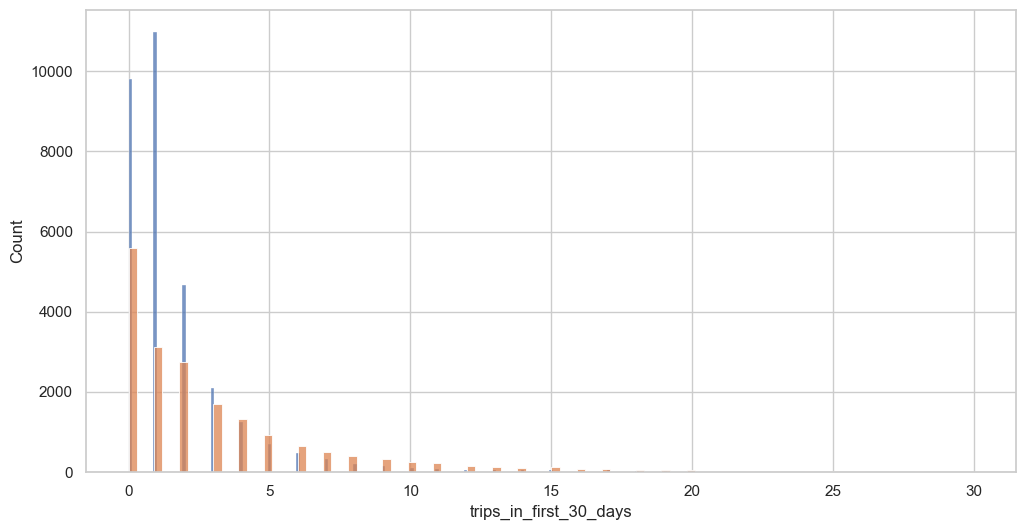

In [35]:
sns.histplot(churn)
sns.histplot(not_churn)

In [36]:
pg.ttest(x=not_churn, y=churn)

T           dof alternative  p-val        CI95%   cohen-d  \
T-test  44.368288  25850.483305   two-sided    0.0  [1.46, 1.6]  0.467906   

       BF10  power  
T-test  inf    1.0

In [37]:
pg.mwu(x=not_churn, y=churn)

U-val alternative  p-val       RBC      CLES
MWU  349565724.5   two-sided    0.0 -0.197307  0.598653

In [38]:
# Бутстреп оценка доверительного интервала для эффекта
def boot(one_dict, two_dict, sample_size, N, r):
    '''
    one_dict - выборка которая предположительно больше
    two_dict - выборка меньше
    sample_size - размер выборки 
    N - количество бутстрепных выборок
    r - количество знаков после запятой
    '''
    diff = []
    dist_mean_one = []
    dist_mean_two = []

    for i in range(N):
        dist_one = np.mean(np.random.choice(
            one_dict, size=sample_size, replace=True))
        dist_two = np.mean(np.random.choice(
            two_dict, size=sample_size, replace=True))
        diff.append(dist_one - dist_two)

        dist_mean_one.append(dist_one)
        dist_mean_two.append(dist_two)

    return (
        round(np.percentile(np.array(diff), 2.5), r),
        round(np.percentile(np.array(diff), 97.5), r),

        # Рисуем графики для выборок
        sns.histplot(dist_mean_one),
        sns.histplot(dist_mean_two)
    )

(1.487, 1.571, <Axes: ylabel='Count'>, <Axes: ylabel='Count'>)

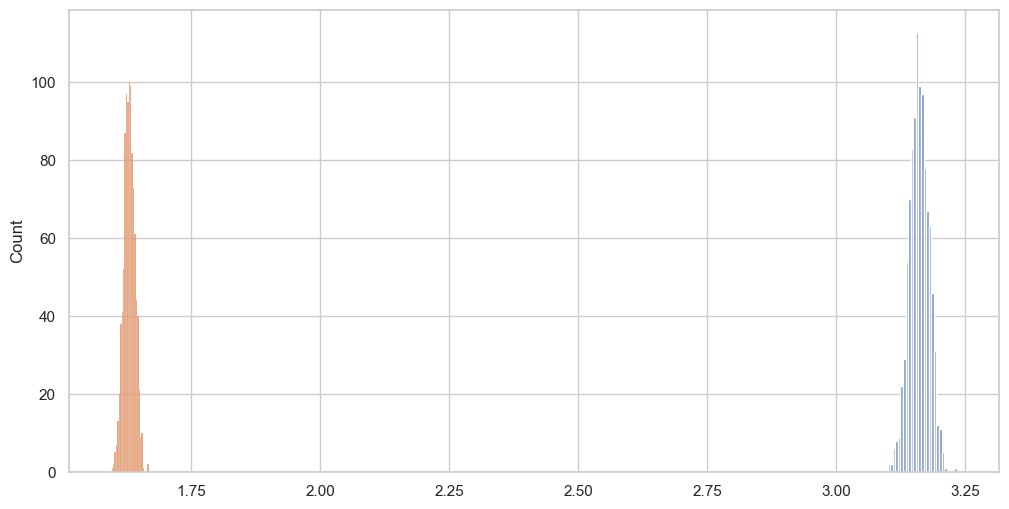

In [39]:
# Доверительный интервал для эффекта
boot(
    one_dict=not_churn,
    two_dict=churn,
    sample_size=50000,
    N=1000,
    r=3
)

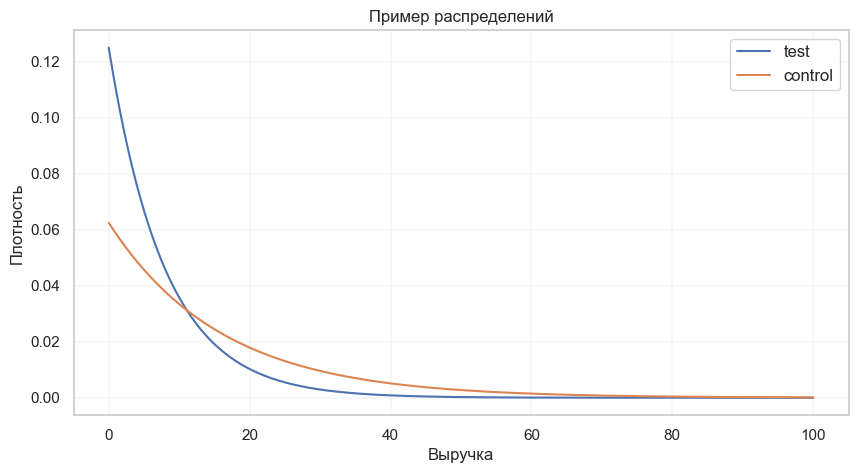

In [40]:
test_dist = expon(scale=8)
control_dist = expon(scale=16)

x = np.linspace(0, 100, 1000)

pyplot.figure(figsize=(10, 5))
pyplot.title('Пример распределений', fontsize=12)
pyplot.plot(x, test_dist.pdf(x), label='test')
pyplot.plot(x, control_dist.pdf(x), label='control')
pyplot.xlabel('Выручка')
pyplot.ylabel('Плотность')

pyplot.legend(fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

In [41]:
def check_criterion(test_dist, control_dist, sample_size, N_exps=500, to_print=True):
    """
        Функция для проверки t-test критерия для AB-теста
        Возвращает доверительный интервал для FPR, если флаг to_print = False. Иначе печатает результат.

        Параметры:
            - test_dist: Распределение тестовой выборки в эксперименте
            - control_dist: Распределение контрольной выборки в эксперименте
            - sample_size: размер выборки теста и контроля
            - N_exps: число экспериментов, по которым потом считается FPR
            - to_print: печатать результат или нет. Если нет, то функция возвращает дов. интервал для FPR.
    """

    # np.random.seed(35)
    bad_cnt = 0
    alpha = 0.05

    for i in range(N_exps):
        # Генерирую выборку
        test = test_dist.rvs(sample_size)
        control = control_dist.rvs(sample_size)

        # Запускаю критерий и считаю p-value
        pvalue = ttest_ind(test, control, equal_var=False,
                           alternative='two-sided').pvalue

        # Проверяю, что pvalue < alpha
        bad_cnt += (pvalue > alpha)

    if to_print:
        print(f"FPR: {round(bad_cnt / N_exps, 4)}")
        print(
            f"CI={proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')}")
        print(f"bad_cnt: {bad_cnt}")
    else:
        return proportion_confint(count=bad_cnt, nobs=N_exps, alpha=0.05, method='wilson')

In [42]:
check_criterion(test_dist=test_dist,
                control_dist=control_dist, sample_size=50000)

FPR: 0.0
CI=(4.336808689942018e-19, 0.007624340461552245)
bad_cnt: 0


In [44]:
scale = np.arange(100, 10000, 1000)
for N in scale:
    left, right = check_criterion(
        test_dist=test_dist, control_dist=control_dist, sample_size=N, N_exps=5000, to_print=False)
    if left < alpha < right:
        print(f"Min sample size: {N}")
        break

In [45]:
check_criterion(test_dist=test_dist, control_dist=control_dist, sample_size=60)

FPR: 0.03
CI=(0.018263213197913387, 0.048903666835945735)
bad_cnt: 15
